# PHYS-E0412 Project - Heat equation in a damper
> Valtteri Turkki

In [1]:
# Imports
import time
import numpy as np
from matplotlib import pyplot as plt
# N.B. Want ot run the notebook quickly? Set this to false
testGridSpacing = False

## 1 Introduction

Shock absorbers are devices that absorb impacts. The way this is usually done is by combining a spring and a damper. In mountain bikes the most typical construction is that the spring is realized with a air chamber and the damper is a piston in an oil cartridge. The volume of the air chamber decreases when the shock absorber is compressed and this provides the spring force, which increases nonlinearly (higher than linear dependence) respect to the used suspension travel. When the shock absorber compresses, the piston moves in the oil. The piston has intentionally holes with spring-loaded cover plates, so that the oil can move through it. The resistance that the holes provide to the fluid flow creates the damping effect of the shock absorber. This means that the damping characteristics depend heavily on the viscosity of the oil, which is affected by temperature.[1] 

This usually makes adjusting suspension tricky as the outside temperature is far from constant and the temperature of the shock absorber also changes during usage as viscous heating and friction from the seal interfaces heat the whole construction. This project aims to model the frictional heating in a simplified model of a mountain bike shock absorber and this way demonstrate the heating effect. The movements of the shock absorber are simulated using measured data obtained with device in [2].


## 2 Background

### 2.1 The working principle of the shock absorber

Introduction explained the working principle of the shock absorber on a high level, so now a more specific case example is used to show the basic construction and then explain the main simplifications that were made to the model. Figure 1 shows a common mountain bike shock absorber (rear shock) cut in half, so that the internal structure can be seen. 

<table class="image">
<caption align="bottom">Figure 1: Image of the internal structure of an air shock. The exact model is Fox Float DPX2 and the image is from https://www.ridefox.com/fox17/help.php?m=bike&id=890 .</caption>
<tr><td><img src="./Data/real_world_damper.png" width="600" /></td></tr>
</table>

The damper in the figure 1 is fully extended and when it is compressed the cylinder on the left goes inside the main body (the part on which the reservoir is attached to) and the length of the damper decreases. The length is defined to be the distance between the center point of the mounting holes that are at the ends of the damper. Travel is defined to be the amount in millimeters that the damper can be compressed, and it is typically around 60 mm. When the length of the damper changes, the piston (with holes) moves inside the cylinder on the left and as the cylinder is filled with oil (light red in figure 1), there is flow resistance through the piston. Since the piston is attached to the piston shaft, the volume inside the cylinder on the left decreases during compression. This is compensated so that the oil can flow inside the piston shaft to the reservoir. The reservoir has a floating piston (solid) separating air and oil. The air inside the reservoir is pressurized to high pressure, typically 250 psi ($\approx$ 17 bar), which makes sure that the oil is pushed back to the cylinder when the damper extends. The damping adjustments are realized via controlling the oil flow from the cylinder to the reservoir.

Frictional heating occurs in the sliding interfaces of the damper. Those are between the cylinder and main body, cylinder and the piston shaft and piston and the cylinder. In the project the focus is on the last interface and its effect on the oil temperature. Thus, the geometry can be simplified quite much. The simplified model used in the simulations is shown in figure 2.


<table class="image">
<caption align="bottom">Figure 2: The simplified geometry used in the simulations of this project. The geometry is simplified from the one shown in figure 1, so that it has rotational symmetry.</caption>
<tr><td><img src="./Data/damper_schematic.png" width="600" /></td></tr>
</table>

In the model the cylinder in which the oil is in is modelled without the piston, but the heating is taken into account by including the seal friction to the model. The heating is modelled to take place at location $s(t)$ given by the suspension usage data. The black circles in figure 2 represent the seals. As the chosen geometry has rotational symmetry along the axis marked with dashed line in figure 2, the problem can be tackled in 2D. This makes it computationally less heavy and makes visualization easier. This means that there are two friction interfaces, which generate heat to the system. The system is assumed to be in air, which can be considered as constant heat sink/source, meaning that $u_{air}$ can be taken as constant. The key dimensions of the system are the length of the cylinder $l$, diameter of the cylinder $d_1$ and the used travel $s$. All the sidewalls are assumed to have thickness $a$. All dimensions are indicated in section 3.1. The materials are aluminium and oil.

### 2.2 The heat transfer model

In this project we will work in a simplified setting and consider only the frictional heating. This means that we are not considering the viscous heating and thus the role of oil in the model is to just act as a heat sink (and we are actually interested in the final temperature of the oil). This means that we can mainly consider heat transfer through conduction as the heat source is located in the aluminium body and the oil is heated by the oil-aluminium interface. 

As we will consider the problem in 2D we use the 2D heat equation. Now, as we have the frictional heating, we must include as source term to the equation. When this is done, the equation used to model the heat transfer becomes
$$
\frac{\partial u}{\partial t} = \frac{\kappa}{\rho c_p}\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + S\right)\,,
$$
where $u(x,y,t)$ is the temperature, $S$ is the source term as heating power per unit area, $\kappa$ is the thermal conductivity in units $\mathrm{[W / (m \cdot K)]}$, $\rho$ is the density in units $\mathrm{[kg / m^3]}$, $c_p$ is the heat capacity (in constant pressure) in units $\mathrm{[J/(kg\cdot K)]}$ and $t$ is time.[3] The source term $S$ is caused by friction and, if we assume that all the work done by friction force $F_\mu$ goes to heat, we can give the source term as
$$
S = \frac{F_\mu |ds|}{\sigma dt}\,,
$$
where $ds$ is the change in used travel (piston position) in an infinitesimal time step $dt$ and $\sigma$ is the area on which the heating power is divided.

In addition to these equations, we need boundary conditions for different interfaces. These interfaces are aluminium-air and aluminium-oil. As air is assumed to have constant temperature, we can write the aluminium-air boundary conditions as
$$
u_{al}(x_{b1}, y_{b1}, t) = u_{out}, \quad t\in \mathbb{R}^+\,,
$$
where $x_{b1}$ and $y_{b1}$ denote boundary coordinates (in this case coordinates where aluminium meets air). The interface between aluminium and oil needs a bit different consideration as oil is not in constant temperature. There the boundary conditions are
\begin{align}
u_{oil}(x_{b2}, y_{b2}, t) &= u_{al}(x_{b2}, y_{b2}, t)\\
\kappa_{oil}\frac{\partial u_{oil}(x_{b2}, y_{b2}, t)}{\partial x} &= \kappa_{al}\frac{\partial u_{al}(x_{b2}, y_{b2}, t)}{\partial x}\\
\kappa_{oil}\frac{\partial u_{oil}(x_{b2}, y_{b2}, t)}{\partial y} &= \kappa_{al}\frac{\partial u_{al}(x_{b2}, y_{b2}, t)}{\partial y}\,,
\end{align}
where $x_{b2}$ and $y_{b2}$ denote boundary coordinates in the aluminium-oil interface and $\kappa$ is the thermal conductivity of the given material.[4, 5] Here ideal thermal connection over the aluminium-oil interface is assumed. With these equations we can describe the heat transfer in the damper in the simplified setting. In the next section we will discretize the equations and use Forward Time Centred Space (FCTS) method to do the simulation.

## 3 Methods

### 3.1 Model discretization

Now let's discretize the heat equation presented in section 2.2 with second difference rule and the use Euler method to complete the FCTS method. First we can start with the spatial derivatives and the source term and write
$$
u_{t_{i,j}} = \frac{\kappa}{\rho c_p} \left(\frac{u_{i-1,j} -2u_{i,j}+u_{i+1,j}}{\Delta x^2} + \frac{u_{i,j-1} -2u_{i,j}+u_{i,j+1}}{\Delta y^2} + \frac{F_\mu (s_{t} - s_{t-1}}{\sigma \Delta t} \right)\,,
$$
where $u_{t_{i,j}}$ is the time derivative and $u_{i,j}$ is the temperature at grid point $i,j$. Next we can choose even grid spacing in $x$ and $y$ directions ($\Delta x = \Delta y$) and apply the Euler method to obtain
$$
u_{i,j,t} = u_{i,j,t-1} + \frac{\kappa\Delta t}{\rho c_p} \left(\frac{u_{i-1,j,t-1}+u_{i+1,j,t-1}+u_{i,j-1,t-1}+u_{i,j+1,t-1}-4u_{i,j,t-1}}{\Delta x^2} + \frac{F_\mu (s_{t} - s_{t-1})}{\sigma \Delta t} \right)\,,
$$
where $u_{i,j,t}$ is the temperature at grid point $i,j$ at time $t$. Now it is worth noting that the source term acts only on the areas where there is an interface and everywhere else it is zero and varnishes from the equation. If we assume that the generated heating power is localized on an area that is defined by the width of the piston seal $w_s$, we can write the area $\sigma$ as follows
$$
\sigma = \pi d_1 w_s\,.
$$

As the heat equation uses second differences, we need to define the edges using boundary conditions. For the aluminium-air interface this is simple as $u_{i,j,t} = u_{out}, \forall t $ when $i,j$ are outer edge points. For the aluminium-oil boundaries we need to apply further discretization. As the interfaces are perpendicular to the $x$ and $y$ directions and the interface boundary condition is defined for perpendicular heat flux, we can inspect only respect one coordinate here [4]. Let's first write the spatial derivatives
$$
\kappa_{al} \frac{u_{i,j,t}-u_{i-1,j,t}}{\Delta x} = \kappa_{oil} \frac{u_{i+2,j,t}-u_{i+1,j,t}}{\Delta x}, \quad \forall t, j \in y_{b2} \,,
$$
where we assume that the boundary lies along $y$ direction between grid points $i,j$ and $i+1,j$, so that aluminium is on the left and oil on the right. Now the first condition gives that we must have $u_{i,j,t}=u_{i+1,j,t}$ and we can solve for $u_{i+2,j,t}$. Here we assume that the heat flows from aluminium to the oil and thus we should already know other terms from the equation above. Solving for $u_{i+2,j,t}$ gives
$$
u_{i+2,j,t} = \frac{(\kappa_{al}+\kappa_{oil})u_{i,j,t} - \kappa_{al} u_{i-1,j,t}}{\kappa_{oil}}, \quad \forall t, j \in y_{b2} \,.
$$
This can also be done the other way around when solving for the heat flux from oil to aluminium.
Since the interface boundary condition defines two points from the oil, we need to apply the heat equation only to the points that are at least three points away from the interface.

With these equations the simulation model can be implemented. The dimensions chosen are presented in the cell below.

In [2]:
# Let's define the physical dimensions in meters
d_1 = 0.03            # Cylinder diameter
l = 0.18              # Cylinder length
a = 0.003             # Cylinder wall tickness
sw = 0.003            # Width of the seal
travel = 0.15         # The damper travel
offset = 0.015         # The amount of empty space in before the piston begins

# Total dimensions required for the discretization grid 0.056x0.8 m
tot_l = 2*a+l
tot_d = 2*a+d_1

### 3.2 The initial data

The initial data obtained with the measurement device in [2] is loaded in the below cell and plotted in figure 3. Since the heating power in the source term $S$ depends on the velocity ($ds/dt$), the data should be rather smooth in order to have the model behave well. The time step of the data is also calculated in the cell below, as that is important when choosing grid spcaing $h$ and considering the stability of the FCTS method.

Data time step is 0.0046794


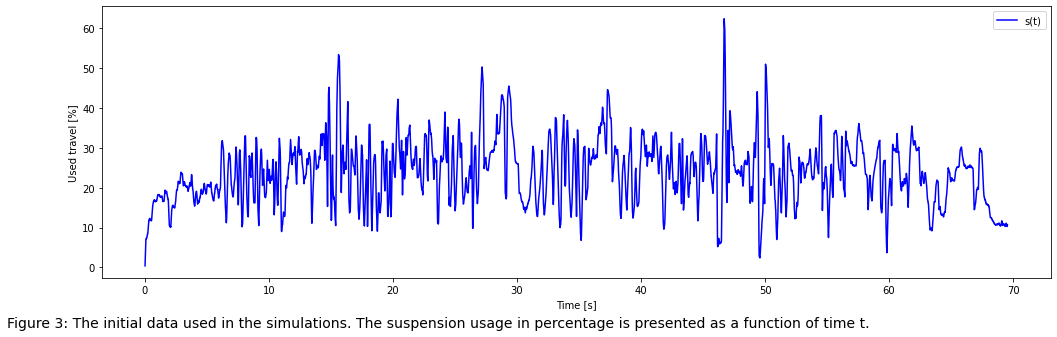

In [4]:
# Load the suspension usage data
data = np.loadtxt('./Data/data.txt', skiprows=0, delimiter=',', usecols=(0,1), unpack=False, dtype=None)
t = np.copy((data[:,0]))
s = np.copy((data[:,1]))
s = s/100   # Transfrom the data from percentage to decimal
dt_data = t[1]-t[0]
print(f'Data time step is {dt_data}')
n_data = t.shape[0] # Number of data points

cap = "Figure 3: The initial data used in the simulations. The suspension usage in percentage is presented as a function of time t."
f = plt.figure(figsize=(17,5))
plt.plot(t, s*100,'b-',label='s(t)')
plt.legend()
plt.ylabel('Used travel [%]')
plt.xlabel('Time [s]')
f.text(.4, -0.01, cap, ha='center', fontsize=14)
plt.show()

Now, as the data in figure 3 looks quite noisy (at least when plotted over the whole 70 second run), the smoothness of the data is verified by applying Fourier transform based filtering. The result of the filtering is shown in figure 4.

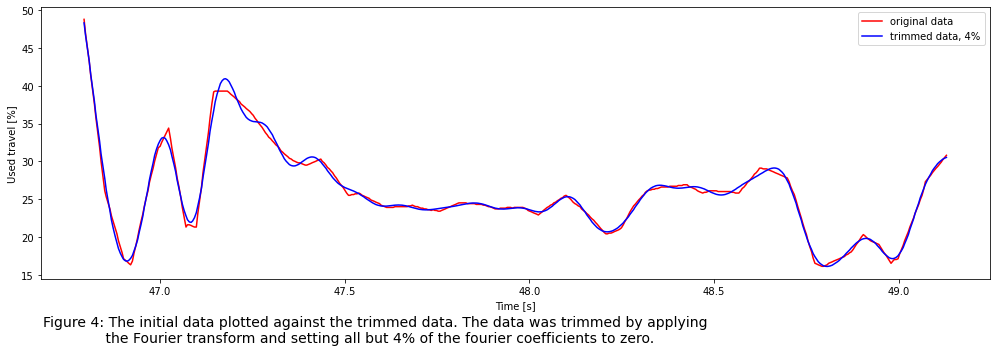

In [5]:
# Smooth the data with Fourier transform
p = 4 # Percentage of the components that will have nonzero value
dft = np.fft.rfft(s)
n = round(s.shape[0]*p/100)
for i in range(n, dft.shape[0]):
    dft[i] = 0
s_idft = np.fft.irfft(dft)

start = 10000
stop = 10500
cap = "Figure 4: The initial data plotted against the trimmed data. The data was trimmed by applying \n the Fourier transform and setting all but 4% of the fourier coefficients to zero."
f = plt.figure(figsize=(17,5))
plt.plot(t[start:stop], s[start:stop]*100, 'r-', label='original data')
plt.plot(t[start:stop], s_idft[start:stop]*100, 'b-', label=f'trimmed data, {p}%')
plt.legend()
plt.ylabel('Used travel [%]')
plt.xlabel('Time [s]')
f.text(.4, -0.05, cap, ha='center', fontsize=14)
plt.show()

From figure 4 we see that the measurement data is reasonably smooth as the Fourier filtering allows to cut 96% of the higher frequencies and the trimmed data still matched the original data. This means that using the raw data in the simulation should not cause any unwanted behavior. Next we generate arbitrary data by adding Gaussian random noise to the smoothed data. This should show well the effect of noise in the simulation. The random noise data is plotted in figure 5.

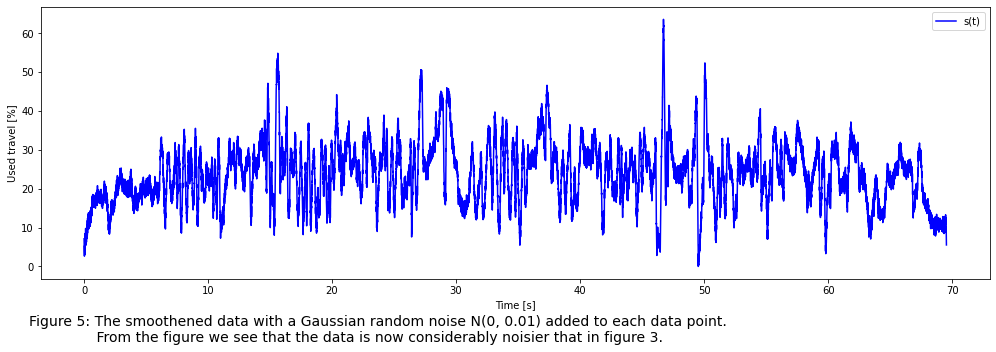

In [6]:
# Generate arbitrary siganl by adding random noise to the smoothed signal
rng = np.random.default_rng() 
noise = 0.01*rng.standard_normal(n_data)
s_rnd = abs(s_idft + noise)

cap = "Figure 5: The smoothened data with a Gaussian random noise N(0, 0.01) added to each data point.\n From the figure we see that the data is now considerably noisier that in figure 3."
f = plt.figure(figsize=(17,5))
plt.plot(t, s_rnd*100,'b-',label='s(t)')
plt.legend()
plt.ylabel('Used travel [%]')
plt.xlabel('Time [s]')
f.text(.4, -0.05, cap, ha='center', fontsize=14)
plt.show()

Using the formula derived in section 3.1 we can define a function that calculates the heating power from the suspension travel data. Here we need to approximate some value for the $F_\mu$ to be able to do the calculations. This value was obtained by taking an empty damper and recording the maximum mass that it can lift without extending, if the mass is attached to the piston shaft. This is may not be the most accurate method, but gives some apprximate for the friction force. When using the initial data and $F_\mu$ = 55 N for the calculations, we get the graph shown in figure 6, where the heating power in Watts is plotted as a function of time.

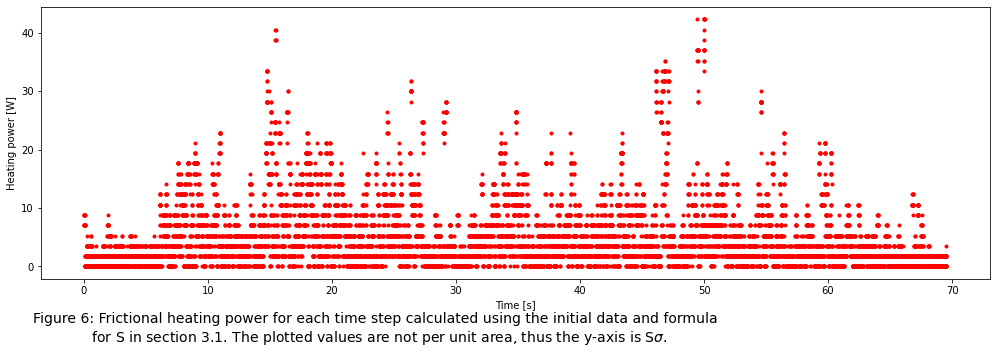

In [7]:
# Calculate the heating power with the time step of the data
# the power is defined at given location s(t) at given time t
def calculatePower(s_data, dt):
    F_mu = 55 # Friction force between the piston and the cylinder in Newtons
    n_data = s_data.shape[0]
    power = np.zeros([n_data-1, 1])
    power = F_mu*np.abs(s_data[1:n_data]-s_data[0:n_data-1])/dt*travel
    return power

cap = "Figure 6: Frictional heating power for each time step calculated using the initial data and formula \n for S in section 3.1. The plotted values are not per unit area, thus the y-axis is S$\sigma$."
powers = calculatePower(s, dt_data)
f = plt.figure(figsize=(17,5))
plt.plot(t[1:], powers, 'r.')
plt.ylabel('Heating power [W]')
plt.xlabel('Time [s]')
f.text(.4, -0.05, cap, ha='center', fontsize=14)
plt.show()

### 3.3 Implementation

The implementation of the simulation is in the below cells: The first cell builds the $n_y\times n_x$ matrix of temperatures. The matrix is built as 3D matrix with 2 values, a material indicator and the temperature, on the third axis. This allowed debugging the model geometry. The indices of the array are bit confusingly in order y and x, but this is done as it makes realizing the rows and columns in the geometry easier. The second cell has the actual simulation wrapped in a function. The function uses a for-loop to iterate over the time dimension and then the spatial dimensions are solved using numpy array operations. The material parameters in the cell below are found from [6].

In [8]:
# The initial parameters and constants
u_out = 20      # Outside temperature in Celcius
rho_al = 2700   # Density of aluminium in [kg/m^3]
rho_oil = 952   # Density of oil in [kg/m^3] (in 25 celcius)
cp_al = 900     # Heat capacity of aluminium in [J/(kg*K)]
cp_oil = 1800   # Heat capacity of oil in [J/(kg*K)] (in 25 celcius)
k_al = 237      # Thermal conductivity of aluminium in [W/(m*K)]
k_oil = 0.180   # Thermal conductivity of oil in [W/(m*K)]

# Build an indicator grid which tells the material of the given grid point and has the temperature on second value
# (oil = 0, alumunium body = 1)
def buildGrid(h):
    n_x = int(round(tot_l/h))
    n_y = int(round(tot_d/h))
    ah = int(round(a/h))
    grid_m = np.zeros([n_y, n_x, 2])
    grid_m[:,:,1] = u_out                # Initialize temperature to outside temperature

    grid_m[0:n_y,0:n_x,0] = 1            # Insert the oil

    grid_m[0:ah,0:n_x,0] = 2       # Insert the sidewalls
    grid_m[n_y-ah:n_y,0:n_x,0] = 2
    grid_m[0:n_y,0:ah,0] = 2
    grid_m[0:n_y,n_x-ah:n_x,0] = 2
    
    # Calculate time step upper limit according to von Neumann stability condition
    dt_max = h**2/np.max([2*k_al/(rho_al*cp_al), 2*k_oil/(rho_oil*cp_oil)])
    print(f'Maximum time step is {dt_max}')

    return grid_m

The basic idea of the implementation is presented here and the code can be found from the cell below:

    > define needed variables and use 'calculatePower()' function to get the power data
    > loop over time values t:
    >    apply the source term to the location given by s[t]
    >    find the heat flux from oil to alloy and define the boundary of allow according to that
    >    solve heat equation in alloy
    >    apply the u_oil = u_al boundary condition for oil
    >    solve heat equation in oil
The algorithm above was presented in [5].

In [9]:
# The main iteration in a function: takes in the initial grid, the time step, the grid spacing, number of intermediate
# frames to be extracted and the suspension usage data

def solveHeatEquation2(grid_m, dt, dx, n_frames, s_data):
    n_x = int(round(tot_l/dx))
    n_y = int(round(tot_d/dx))
    # Define the interface coordinates (inside edges of the alloy body)
    interface_y_1 = int(round(a/dx))-1
    interface_y_2 = int(round(n_y-a/dx))
    interface_x_1 = interface_y_1
    interface_x_2 = int(round(n_x-a/dx))
    iw = int(round(sw/dx))
    
    grid = np.copy(grid_m)
    temp_m = np.copy(grid)             # The update grid
    n_data = s_data.shape[0]
    pwr = calculatePower(s_data, dt)   # Obtain the power at each time
    c = k_al*dt/(rho_al*cp_al*dx**2)        # Constants for alloy
    frame_dist = round(n_data/n_frames)
    ret_grid = np.empty([grid.shape[0], grid.shape[1], n_frames])
    count = 0
    
    # Iterate over all the time steps
    for t_iter in range(1,n_data):

        # First the source term
        loc = int(round(offset/dx+s_data[t_iter]*travel/dx))
        p_t = pwr[t_iter-1]
        for i in range(0,iw):
            temp_m[interface_y_1, loc+i,1] = grid[interface_y_1, loc+i,1] + k_al*dt/(rho_al*cp_al*sw*np.pi*d_1)*p_t
            temp_m[interface_y_2, loc+i,1] = grid[interface_y_2, loc+i,1] + k_al*dt/(rho_al*cp_al*sw*np.pi*d_1)*p_t
        
        
        # Use the heat flux boundary condition for alloy
        grid[interface_y_1-1,interface_x_1+1:interface_x_2,1] = (k_al*grid[interface_y_1,interface_x_1+1:interface_x_2,1] + k_oil*grid[interface_y_1+1,interface_x_1+1:interface_x_2,1] - k_oil*grid[interface_y_1+2,interface_x_1+1:interface_x_2,1])/k_al
        grid[interface_y_2+1,interface_x_1+1:interface_x_2,1] = (k_al*grid[interface_y_2,interface_x_1+1:interface_x_2,1] + k_oil*grid[interface_y_2-1,interface_x_1+1:interface_x_2,1] - k_oil*grid[interface_y_2-2,interface_x_1+1:interface_x_2,1])/k_al
        grid[interface_y_1+1:interface_y_2,interface_x_1-1,1] = (k_al*grid[interface_y_1+1:interface_y_2,interface_x_1,1] + k_oil*grid[interface_y_1+1:interface_y_2,interface_x_1+1,1] - k_oil*grid[interface_y_1+1:interface_y_2,interface_x_1+2,1])/k_al
        grid[interface_y_1+1:interface_y_2,interface_x_2+1,1] = (k_al*grid[interface_y_1+1:interface_y_2,interface_x_2,1] + k_oil*grid[interface_y_1+1:interface_y_2,interface_x_2-1,1] - k_oil*grid[interface_y_1+1:interface_y_2,interface_x_2-2,1])/k_al
            
        # Then solve the bulk alloy
        u_xx = grid[1:interface_y_1-1,0:n_x-2,1] + grid[1:interface_y_1-1,2:n_x,1] - 2*grid[1:interface_y_1-1,1:n_x-1,1]
        u_yy = grid[0:interface_y_1-2,1:n_x-1,1] + grid[2:interface_y_1,1:n_x-1,1] - 2*grid[1:interface_y_1-1,1:n_x-1,1]
        temp_m[1:interface_y_1-1,1:n_x-1,1] = grid[1:interface_y_1-1,1:n_x-1,1] + c*(u_xx+u_yy)

        u_xx = grid[2+interface_y_2:n_y-1,0:n_x-2,1] + grid[2+interface_y_2:n_y-1,2:n_x,1] - 2*grid[2+interface_y_2:n_y-1,1:n_x-1,1]
        u_yy = grid[1+interface_y_2:n_y-2,1:n_x-1,1] + grid[3+interface_y_2:n_y,1:n_x-1,1] - 2*grid[2+interface_y_2:n_y-1,1:n_x-1,1]
        temp_m[2+interface_y_2:n_y-1,1:n_x-1,1] = grid[2+interface_y_2:n_y-1,1:n_x-1,1] + c*(u_xx+u_yy)

        u_xx = grid[interface_y_1:interface_y_2, 0:interface_x_1-1,1] + grid[interface_y_1:interface_y_2, 2:interface_x_1+1,1] - 2*grid[interface_y_1:interface_y_2, 1:interface_x_1,1]
        u_yy = grid[interface_y_1-1:interface_y_2-1, 1:interface_x_1,1] + grid[interface_y_1+1:interface_y_2+1, 1:interface_x_1,1] - 2*grid[interface_y_1:interface_y_2, 1:interface_x_1,1]
        temp_m[interface_y_1:interface_y_2, 1:interface_x_1,1] = grid[interface_y_1:interface_y_2, 1:interface_x_1,1] + c*(u_xx+u_yy)

        u_xx = grid[interface_y_1:interface_y_2, interface_x_2:n_x-2,1] + grid[interface_y_1:interface_y_2, interface_x_2+2:n_x,1] - 2*grid[interface_y_1:interface_y_2, interface_x_2+1:n_x-1,1]
        u_yy = grid[interface_y_1-1:interface_y_2-1, interface_x_2+1:n_x-1,1] + grid[interface_y_1+1:interface_y_2+1, interface_x_2+1:n_x-1,1]- 2*grid[interface_y_1:interface_y_2, interface_x_2+1:n_x-1,1]
        temp_m[interface_y_1:interface_y_2, interface_x_2+1:n_x-1,1] = grid_m[interface_y_1:interface_y_2, interface_x_2+1:n_x-1,1] + c*(u_xx+u_yy)


        # Imply the boundary conditions to oil
        temp_m[interface_y_1+1,interface_x_1+1:interface_x_2,1] = temp_m[interface_y_1,interface_x_1+1:interface_x_2,1]
        temp_m[interface_y_2-1,interface_x_1+1:interface_x_2,1] = temp_m[interface_y_2,interface_x_1+1:interface_x_2,1]
        temp_m[interface_y_1+1:interface_y_2,interface_x_1+1,1] = temp_m[interface_y_1+1:interface_y_2,interface_x_1,1]
        temp_m[interface_y_1+1:interface_y_2,interface_x_2-1,1] = temp_m[interface_y_1+1:interface_y_2,interface_x_2,1]

        
        # Solve oil
        u_xx = grid[interface_y_1+2:interface_y_2-1,interface_x_1+1:interface_x_2-2,1] + grid[interface_y_1+2:interface_y_2-1,interface_x_1+3:interface_x_2,1]-2*grid[interface_y_1+2:interface_y_2-1,interface_x_1+2:interface_x_2-1,1]
        u_yy = grid[interface_y_1+1:interface_y_2-2,interface_x_1+2:interface_x_2-1,1] + grid[interface_y_1+3:interface_y_2,interface_x_1+2:interface_x_2-1,1] - 2*grid[interface_y_1+2:interface_y_2-1,interface_x_1+2:interface_x_2-1,1]
        temp_m[interface_y_1+2:interface_y_2-1,interface_x_1+2:interface_x_2-1,1] = grid[interface_y_1+2:interface_y_2-1,interface_x_1+2:interface_x_2-1,1] + k_oil*dt/(rho_oil*cp_oil*dx**2)*(u_xx+u_yy)

        # Update the grid
        grid = temp_m

        # Save the current frame if it is nth frame
        if(t_iter%frame_dist == 0 or t_iter == n_data-1):
            if(count < n_frames):
                ret_grid[:,:,count] = np.copy(grid[:,:,1])
                count = count + 1

    return ret_grid



In [10]:
# Artificial suspension usage data for testing grid spacing
t_art = np.linspace(0,30,200000)
s_art = np.ones(t_art.shape[0])*0.3
s_art = s_art + 0.1*np.sin(t_art*np.pi/30) + 0.2*np.sin(t_art*np.pi/3) + 0.15*np.sin(t_art*np.pi/10) + 0.1*np.sin(t_art) + 0.1*np.sin(t_art*5) + 0.05*np.sin(t_art*15)
s_art = np.abs(s_art)
dt_art = t_art[1]-t_art[0]
print(f'Artificial data time step is {dt_art}')

def plotArtificialData():
    plt.figure(figsize=(10,3))
    plt.plot(t_art, s_art*100,'b-',label='s(t)')
    plt.legend()
    plt.ylabel('Used travel [%]')
    plt.xlabel('Time [s]')
    plt.show()

Artificial data time step is 0.00015000075000375


In [11]:
# Solve the model with initial data
n = 10
h = 0.001
grid_m = buildGrid(h)
t_distr = solveHeatEquation2(grid_m, dt_data, h, n, s)
print(f'Maximum temperature for raw data is {round(np.max(t_distr[:,:,n-1]),2)}')

Maximum time step is 0.005126582278481013
Maximum temperature for raw data is 32.51


In [12]:
# Solve the model with random data
t_distr_rnd = solveHeatEquation2(grid_m, dt_data, h, n, s_rnd)
print(f'Maximum temperature for noisy data is {round(np.max(t_distr_rnd[:,:,n-1]),2)}')

Maximum temperature for noisy data is 73.82


In [13]:
# Define a function for plotting obatined solutions, distr is the result grid, a and b are y and x coordinates of lines
# along which the time evolutio is plotted
def plotSolution(distr, a, b, t_axis, cap1, cap2, frame=0):
    # Plot the heatmap
    last = distr.shape[2]-1
    if(frame == 0):
        frame = last
    n_x = distr.shape[1]
    n_y = distr.shape[0]
    n_data = t_axis.shape[0]
    f1 = plt.figure(figsize=(17,10))
    im = plt.imshow(distr[:,:,frame], 'inferno')
    f1.text(.4, 0.3, cap1, ha='center', fontsize=14)
    plt.show()
    # Make a side by side plot that shows the evolution on a line along x-axis and y-axis
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set(figheight=5,figwidth=12)
    for i in range(1,last):
        ax1.plot(np.linspace(0,tot_l, n_x),distr[a,:,i], label=f'Time t={round((i+1)/n*t_axis[n_data-1],1)} s')
        ax2.plot(np.linspace(0,tot_d, n_y),distr[:,b,i], label=f'Time t={round((i+1)/n*t_axis[n_data-1],1)} s')
    ax1.set(xlabel='Position in the damper x [m]', ylabel='Temperature [$^\circ$C]')
    ax2.set(xlabel='Position in the damper y [m]', ylabel='Temperature [$^\circ$C]')
    plt.legend()
    fig.text(.4, -0.05, cap2, ha='center', fontsize=14)
    plt.show()

In [14]:
# Test the effect of initial temperature
test_u = np.array([-5, 0, 10, 20, 25, 30, 40])
u_max = np.empty(test_u.shape)
for k in range(0,len(test_u)):
    test_h = 0.001
    test_grid = np.copy(grid_m)
    test_grid[:,:,1] = test_u[k]/u_out*test_grid[:,:,1]
    res = solveHeatEquation2(test_grid, dt_data, test_h, 1, s)
    u_max[k] = np.max(res[:,:,0])

In [32]:
# Define a fucntion that plots the results for initial temperature
def plotInitialTemperatureTest(cap):
    f = plt.figure()
    plt.plot(test_u, u_max)
    plt.xlabel('Initial temperature $u_{out}$ [$^\circ$C]')
    plt.ylabel('Maximum temperature after the simulation [$^\circ$C]')
    f.text(.4, -0.15, cap, ha='center', fontsize=14)
    plt.show()

In [16]:
# Test the running times
reps = 20
times = np.empty(reps)
for k in range(0,reps):
    t0 = time.time()
    res = solveHeatEquation2(test_grid, dt_data, h, 1, s)
    t1 = time.time()
    times[k] = (t1-t0)

In [17]:
def timingTest():
    # Print the results of timing
    print(f'The mean time was {np.mean(times)} s')
    print(f'with standard deviation {np.std(times)} s')
    print(f'number of samples was {reps}')

In [18]:
# Test the effect of grid spacing on solution times, takes about 2 hours (8000 s) to run
h_test = [0.001, 0.0005, 0.00025]
h_reps = 5
h_times = np.empty((len(h_test),h_reps))
if(testGridSpacing):
    for i in range(0,len(h_test)):
        j = 0
        grid_h = buildGrid(h_test[i])
        while(j < h_reps):
            t0 = time.time()
            t_distr_art = solveHeatEquation2(grid_h, dt_art, h_test[i], 1, s_art)
            t1 = time.time()
            h_times[i,j] = (t1-t0)
            j = j + 1

Maximum time step is 0.005126582278481013
Maximum time step is 0.0012816455696202532
Maximum time step is 0.0003204113924050633


In [38]:
# Plots the results of the grid spacing testing
def gridSpacingTest(cap):
    if(testGridSpacing):
        f = plt.figure()
        avg = np.mean(h_times, axis=1)
        std = np.std(h_times, axis=1)
        plt.errorbar(h_test, avg, std)
        plt.xlabel('Grid spacing h [m]')
        plt.ylabel(f'Average running time (n={h_reps}) [s]')
        f.text(.4, -0.15, cap, ha='center', fontsize=14)
        plt.show()
    else:
        print(f'testGridSpacing variable is set to {testGridSpacing}.')

In [42]:
# The figure captions for results section
cap71 = f"Figure 7.1: The obtained final temperature distribution (at t = {t[n_data-1]} s) with the initial data. We see that the heat is quite localized \n around the average used travel."
cap72 = "Figure 7.2: The time evolution of the heating in the damper model along x- and y-lines. We se that the temperature increases \n quite steadily thorough the siulation."
cap81 = f"Figure 8.1: The obtained final temperature distribution (at t = {t[n_data-1]} s) with the random noise data. \n The result is quite similar to figure 7.1."
cap82 = "Figure 8.2: Time evolution of the distribution seen in figure 8.1. The difference compared to figure 7.2 is that \n the temperatures are higher due to the increased heating."
cap9 = "Figure 9: The results of testing the simulation with different values for $u_{out}$. We see that the\n final maximum temperature depends linearly from $u_{out}$, as expected."
cap10 = "Figure 10: The effect of grid spacing on the simulation running time. Going for four times\n tighter spacing increases the running time nearly 10 times. The vertical lines in the\n figure are the standard deviations of the running times."

## 4 Results

### 4.1 The temperature distribution

When the simulation is run with the raw initial data shown in section 3.2, the solution in figure 7.1 is obtained for the final temperature distribution. The maximum temperature is at the interface, where the friction between seal and aluminium cylinder occurs. Furthermore, we see that the heat is concentrated around the average used travel, which is around 50 in figure 7.1. The maximum temperature is 32.51 $^\circ$C, which is 12.51 $^\circ$C above the initial temperature. This is quite much as and means that the heating effect is indeed visible in the damper. The fact that the model doesn't consider convection forces the heat to propagate only with conduction. This is seen well in figure 7.1 as the oil is heated only from a relatively small area and there would probably be more even distribution, if convection was taken into account.

The time evolution of the solution is plotted along axes $y=4$ and $x=54$ in figure 7.2. There we see that the temperature increases over the whole simulation. The left plot in figure 7.2 shows how the heating is affected by the suspension usage in a way that the heating location varies. This is why the peak shifts in x-direction during the simulation. The plot also tells that since heat does not propagate so well in oil, the areas, where the piston does not visit are not heated at all. The right plot in figure 7.2 is symmetric around the center line of the damper, which is logical as the seal friction occurs on both sides of the damper. We see that the temperature decreases when we deviate from the heating interface. The slope of the deviation is much steeper in aluminium, which is due to the better thermal conductance and the fact that outside air works as a heat sink. The flat spot is caused by the boundary condition, where we have $u_{i}=u_{i+1}$ on the boundary.

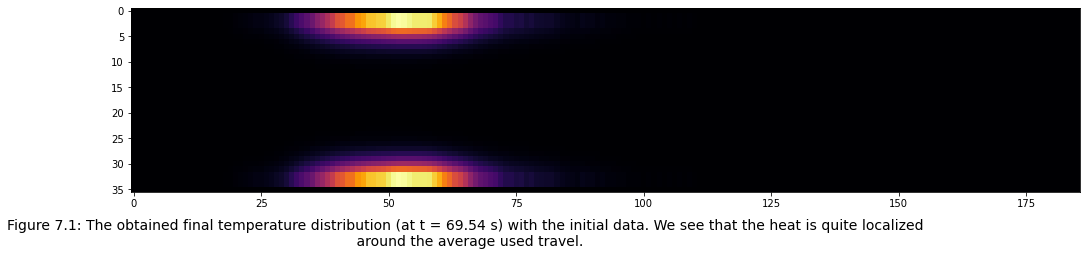

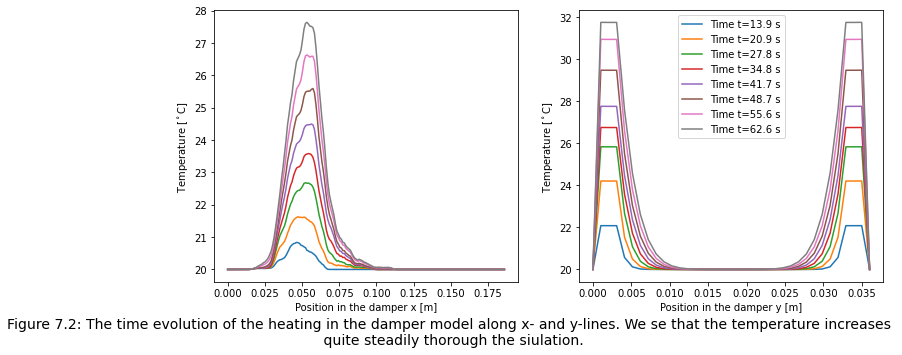

In [21]:
plotSolution(t_distr, 4, 54, t, cap71, cap72)

The effect of noise in data was demonstrated by adding random noise to the data. The added noise was drawn from normal distribution with mean zero and standard deviation 0.01. The addition was done to the smoothed data, so that the effect of it would be even more clear. The obtained solution is plotted in figures 8.1 and 8.2 in a similar way as for the initial data above. This time the maximum temperature in the end is 73.82 $^\circ$C, which is significantly higher than in the initial case. The reason for this is that the source term depends essentially on the velocity at which the damper is compressed, $S \propto \left|\frac{ds}{dt}\right|=|dv_{damper}| $. Thus, adding random noise to the position data makes the derivative of position, velocity, even more noisy and thus the heating power by friction increases.

The time evolution plots in figure 8.2 are nearly identical to the initial data simulation with the exception that the peaks are higher. The x-axis plot shows well the fact that spiky data causes oscillations and there are two peaks seen from 27.8 s to 55.8 s lines. These peaks are due to the fact that the damper oscillates both at the frequency determined by the physical event (bike riding) and because of the noise and since the noise has much higher frequency, the spikes seen in the initial data case split into two peaks that are around the original spike.

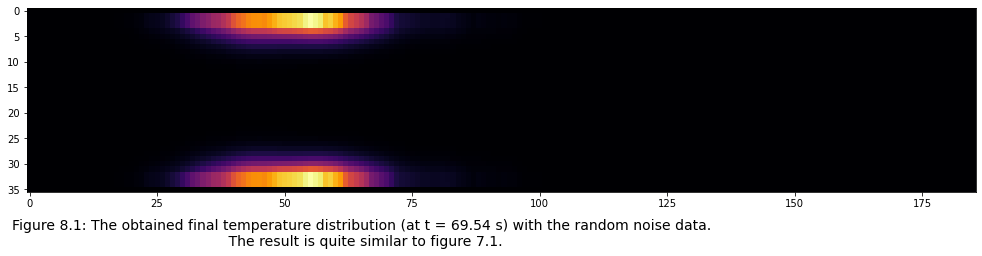

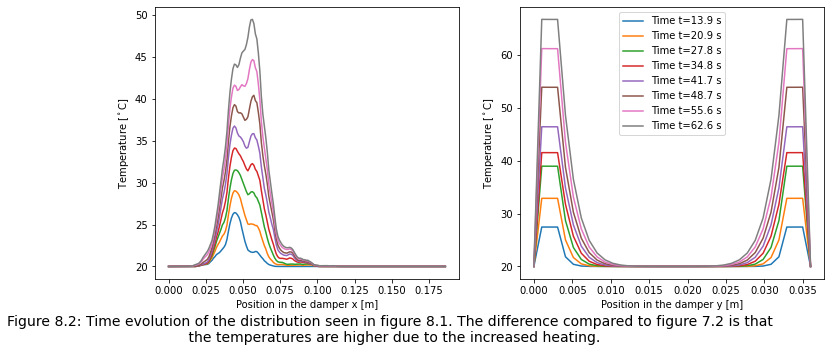

In [22]:
plotSolution(t_distr_rnd, 4, 54, t, cap81, cap82)

### 4.2 The effect of initial temperature $u_{out}$

The effect of initial temperature was tested also with temperatures of $u_{out}$ = (-5, 0, 10, 20, 25, 30, 40)$^\circ$C. Since these tests were made with the same assumption that we start from thermal equilibrium, the result is just a linear dependence as the heating in the interface always adds the same amount of heat e.g., temperature difference, to the system. The result is plotted in figure 9.

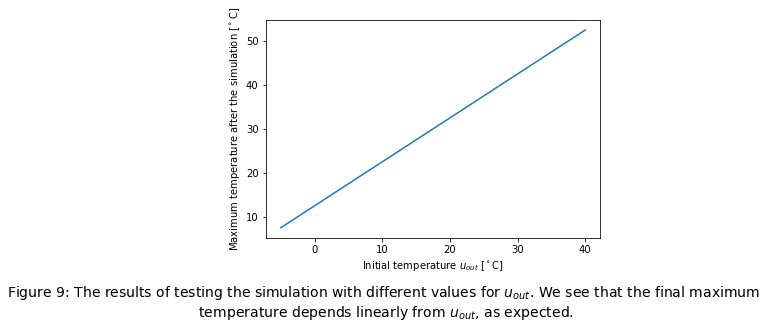

In [35]:
plotInitialTemperatureTest(cap9)

### 4.3 The implementation performance

Finally the speed of the implementation was tested by running it 20 times with the initial data and taking the average and standard deviation of the running times. This gave the results shown below.

In [24]:
timingTest()

The mean time was 7.267440223693848 s
with standard deviation 0.4277153187928174 s
number of samples was 20


It would have been great to investigate the effect of grid spacing on the running times, but the discretization grid spacing cannot be altered much as the von Neumann stability condition requires $\Delta t <$ 0.005 s with $h$ = 0.001 m and the initial data has time step of 0.004 s. If $h$ is decreased from 0.001, the requirement for time step $\Delta t$ decreses quadratically and the data cannot be used (at least without interpolation). 

This is why an artificial dataset with $\Delta t =$ 0.00015 s was constructed. This dataset had 200000 data points generated using numpy linspace and sine waves with different frequencies and amplitudes. With that data, it was possible to test grid spacings down to 0.00025 m. The tests were made with values $h$= (0.001, 0.0005, 0.00025) m and five repeats for each value. The results are plotted in figure 10, where the data points are mean running times and errors are the standard deviations. From the plot we can see that the running time increases dramatically, when grid spacing is tightened.

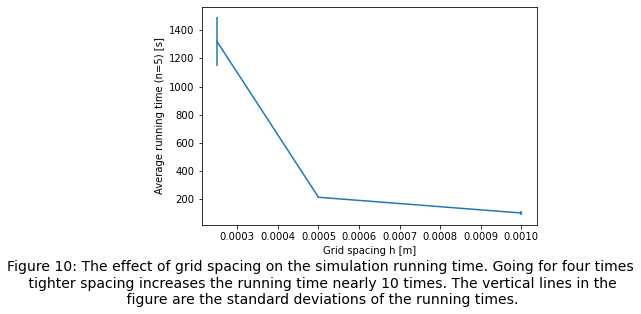

In [43]:
gridSpacingTest(cap10)

## 5 Discussion

The results of this project were as expected as the increase in temperature is reasonable, around 10 $^\circ$C. If one compares that to the behaviour of suspension in cold temperatures (-5$^\circ$C or lower), the results agree as in cold the suspension is initially very stiff due to the increased viscosity of the oil, but then friction heats up the oil and the behaviour of the suspension starts to be like in summer temperatures (10$^\circ$C or above). Though, this seems promising, we must take into account that the used model is heavily simplified: It ignores the flow of the oil, piston shaft friction and the viscous heating. These contribute to the heat distribution and mean that in reality the distribution in the oil is much more complicated than the 2D plots shown in figures 7.1 and 8.1. Another fact that should be considered, if studying air shocks, is that the air chamber works as an insulator for the oil cylinder and that changes the heat sink effect of outside air [1]. Also, the compressions are usually fast, so the process is adiabatic from thermodynamical point of view, and this causes even more heating effect in the air shock case.

With all the simplifications this project was more of a toy model for the problem than an actual simulation that could be used for instance for engineering purposes. The usefulness of the results is not the best, but those can be used to approximate the amount of heating in damper, which cis useful when choosing the correct viscosity of oil for each environment (temperature and track combination).

Future improvements for the project could be including the oil flow as well as taking into account the dynamics of the system e.g., having a moving piston in the oil and modelling the volume compensation of the reservoir in some way. Implementation-wise the code could be improved by making a more clever way for the array indexing as currently the logic works with just hard-coded indexing. That is not optimal for readability or modifiability. The current implementation speed is decent as the solutions take only less than minute for the $h=$ 0.001 m initial data case. Improving that in future would be quite difficult as the for-loop over time cannot be parallelized as consecutive iterations depend on each other. One possibility would be to solve the spatial equations in parallel on each time step, if the complexity would grow so much that it would be needed.

In addition to the above mentioned improvements, it would be interesting to study the differences between air and spring shock absorbers from the heating perspective. This would use the more complicated dynamics included models and would give more accurate results for the heat distributions. That would also be a feasible topic from the perspective of the sport as the debated between air and coil (spring) dampers is currently active. 

## References

[1] Redfield R.C., "Thermal modeling in mountain bike air shocks.", _Procedia Engineering_, 2.2, 2010, 2625-2630

[2] Turkki V., "DIY suspension wizard - mountain bike suspension data logger", _Mechatronics exercises Aalto University_, 2021, https://wiki.aalto.fi/display/MEX/DIY+suspension+wizard+-+mountain+bike+suspension+data+logger, accessed 25.4.2022

[3] Milan H., "Analytical solution of the Diffusion/Heat equation in time-domain for two-dimensions.", 30.1.2017, https://hugomilan.github.io/tlmbht/theory/ana/heat/heat-2D-TTqq.html, accessed 27.4.2022

[4] "Interface Boundary Condition", _Nuclear Power_, https://www.nuclear-power.com/nuclear-engineering/heat-transfer/thermal-conduction/heat-conduction-equation/interface-boundary-condition/, accessed 29.4.2022

[5] Roe B., Jaiman R., Haselbacher A., Geubelle P.H., "Combined interface boundary condition method for coupled thermal simulations.", _International journal for numerical methods in fluids_, 2008, 57(3), pp.329-354.

[6] Seppänen R., Kervinen M., Parkkila I., Karkela L., Meriläinen P., "MAOL-taulukot.", _Helsinki: Otava_, 2006